<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-the-data" data-toc-modified-id="Import-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import the data</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Functions-for-MLE-and-plotting-single-fitness-effect-and-mutation-rate" data-toc-modified-id="Functions-for-MLE-and-plotting-single-fitness-effect-and-mutation-rate-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Functions for MLE and plotting single fitness effect and mutation rate</a></span></li><li><span><a href="#Functions-for-MLE-and-plotting-for-2-different-fitness-effects-and-mutation-rates" data-toc-modified-id="Functions-for-MLE-and-plotting-for-2-different-fitness-effects-and-mutation-rates-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Functions for MLE and plotting for 2 different fitness effects and mutation rates</a></span></li></ul></li><li><span><a href="#MLE-for-mLOX-with-single-fitness-and-mutation-rate" data-toc-modified-id="MLE-for-mLOX-with-single-fitness-and-mutation-rate-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MLE for mLOX with single fitness and mutation rate</a></span></li><li><span><a href="#MLE-for-mLOX-with-2-fitnesses-(s1,-s2)-and-2-mutation-rate-(mu1,-mu2)" data-toc-modified-id="MLE-for-mLOX-with-2-fitnesses-(s1,-s2)-and-2-mutation-rate-(mu1,-mu2)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MLE for mLOX with 2 fitnesses (s1, s2) and 2 mutation rate (mu1, mu2)</a></span></li></ul></div>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [1]:
# imported packages
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.special
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
import numpy as np
import math
import zipfile

In [2]:
plt.style.use('cwpython.mplstyle') #use custom style file

In [3]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [4]:
loss_color = '#a6cee3'

In [5]:
gain_lower = 0.025
gain_upper = 0.999
loss_lower = 0.041
loss_upper = 0.67
CNLOH_lower = 0.015
CNLOH_upper = 0.54
no_limit = 0.999

In [6]:
mCA_type = '-'
capped_or_not = 'capped'

# Import the data

In [7]:
total_people = 502411

# Functions

In [34]:
def log_logit_CFs(df, lower_limit, upper_limit):
    df_copy = df.copy(deep = True)
    CFs_mCA = df_copy['true_freq'].to_list()
    
    logitCFs = []
    logCFs = []
    
    for i in CFs_mCA:
        if lower_limit <= (i) <= upper_limit:
            logitCFs.append(scipy.special.logit(float(i)))
            logCFs.append(np.log(float(i)))

    print('total mCAs = '+str(len(logitCFs)))
    return logCFs, logitCFs

In [9]:
def cumulative_cell_fraction_densities_list(logit_cell_fractions, total_people):

    logit_cell_fractions = sorted(logit_cell_fractions, reverse = True)

    cumulative_number = np.arange(np.size(logit_cell_fractions))/total_people
    log_cumulative_number = np.log(cumulative_number)

    densities = []
    for a, b in zip(logit_cell_fractions, log_cumulative_number):
        if math.isinf(b) == False:
            densities.append((a, b))

    return densities

In [10]:
def create_shortened_datapoint_list(logit_cell_fractions):
    sorted_logit_cell_fractions = sorted(logit_cell_fractions)

    hist, bins = np.histogram(logit_cell_fractions, bins='doane', range=(min(logit_cell_fractions),max(logit_cell_fractions)))

    bins_ranges = []
    for i in range(0, len(bins)-1):
        bins_ranges.append((bins[i], bins[i+1]))

    bins_keys = {}
    for cf in sorted_logit_cell_fractions:
        for bins in bins_ranges:
            if bins[0]<=cf<bins[1]:
                if bins in bins_keys.keys():
                    bins_keys[bins].append(cf)
                else:
                    bins_keys[bins]=[cf]
    bins_keys

    shortened_logit_list = []
    for k, v in bins_keys.items(): #take the 1st and middle logit cell fraction from each bin
        shortened_logit_list.append(v[0])
        list_length = len(v)
        if list_length>=2:
            shortened_logit_list.append(v[int(len(v)/2)])

    if list_length>1:
        shortened_logit_list.append(sorted_logit_cell_fractions[-1]) #make sure the final datapoint is in the list (i.e. both first and last will be there)

    return shortened_logit_list

In [11]:
def Probtheory(l, params): #= predicted density (i.e. normalised by mu)
    total_density=0.0
    N = 9.40166610e+04 #N inferred from DNMT3A R882H

    s=params[0]

    age40_49_ratio = 119000/(119000+168000+213000)
    age50_59_ratio = 168000/(119000+168000+213000)
    age60_69_ratio = 213000/(119000+168000+213000)

    total_density= age40_49_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))*(1-np.exp(l))))))*\
                             (1/9.99), 40, 49.99))[0]+\
              age50_59_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))*(1-np.exp(l))))))*\
                             (1/9.99), 50, 59.99))[0]+\
               age60_69_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))*(1-np.exp(l))))))*\
                             (1/9.99), 60, 69.99)[0])

    return total_density

In [12]:
def Probtheory_logit_cumulative(integral_limit, l, params): #= predicted cumulative density
    total_density=0.0
    N = 9.40166610e+04 #N inferred from DNMT3A R882H
    sigma = 8.1
    mean = 56.53
    dt=0.1

    s = params[0]

    age40_49_ratio = 119000/(119000+168000+213000)
    age50_59_ratio = 168000/(119000+168000+213000)
    age60_69_ratio = 213000/(119000+168000+213000)

    cumulative = (integrate.quad(lambda l: ((integrate.quad(lambda t: (N*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))))))*(1/9.99), 40, 49.99))[0]*age40_49_ratio+\
                                            (integrate.quad(lambda t: (N*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))))))*(1/9.99), 50, 59.99))[0]*age50_59_ratio+\
                                            (integrate.quad(lambda t: (N*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(N*s))))))*(1/9.99), 60, 69.99))[0]*age60_69_ratio), l, scipy.special.logit(integral_limit)))

    return np.log(cumulative[0])

## Functions for MLE and plotting single fitness effect and mutation rate

In [13]:
def error_bars(hist, normed_value, widths):

    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]

    return err

In [14]:
def ProbDataGivenModel_logit_cumulative_subsample(params, data, integral_limit):
    x = []
    for datapoint in data:
        logit_cell_fraction = datapoint[0]
        if scipy.special.expit(logit_cell_fraction) <1.0:
            x.append(logit_cell_fraction)

    #just select some of the datapoints to calculate the cumulative for...
    sampled_logit_cell_fractions = create_shortened_datapoint_list(x)
#     print('number of datapoints (subsampled) = ', len(sampled_logit_cell_fractions))

    predicted_cumulative_subsampled = [Probtheory_logit_cumulative(integral_limit, l, params) for l in sampled_logit_cell_fractions]

    predicted_inter = interp1d(sampled_logit_cell_fractions, predicted_cumulative_subsampled, fill_value = 'extrapolate')

    interpolated_predicted_cumulative = predicted_inter(x)

    x_y_dict = {}
    for a, b in zip(x, interpolated_predicted_cumulative):
        if math.isnan(b) == False:
            x_y_dict[a]=b #a dictionary of the x and y datapoints of the cumulative theory (but only of the sampled logit spaced cell fractions)

    total_square_distance = 0
    for datapoint in data:
        logit_cell_fraction = datapoint[0]
        mutation_rate = params[1]
        if mutation_rate >0:
            if np.exp(logit_cell_fraction) <1.0:
                if logit_cell_fraction in x_y_dict.keys(): #i.e. only calculate the square distance for a reduced sample of the logit cell fractions
                    predicted_log_density = x_y_dict[logit_cell_fraction]
                    actual_density = np.exp(datapoint[1])
                    actual_density_mu = actual_density/mutation_rate
                    actual_log_density_mu = np.log(actual_density_mu)
                    if actual_log_density_mu >0: #the first actual density will always be inf so ignore this (as will end up summing all the total square distance to inf)
                        square_distance = ((actual_log_density_mu - predicted_log_density)**2)
                        total_square_distance = total_square_distance + square_distance
        if mutation_rate <0: #if it tries to fit a negative mutation rate... make the total square distance very large
            total_square_distance = 1000000

    return total_square_distance

In [15]:
def heatmap_logit_cumulative_subsample(cumulative_densities_list, s_range, mu_range, grid_size, mCA, labelname, integral_limit):
    # Plotting the maximum likelihood estimates on a colormesh plot
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(16, 7))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)

    axisfont=15
    titlefont=18
    axislabelfont=18
    m_size=8
    scale = 1

    s_list = np.linspace(s_range[0], s_range[1], grid_size) #list of possible values for s
    mu_list = np.logspace(np.log10(mu_range[0]), np.log10(mu_range[1]), grid_size) #list of possible values for mu

    #MLE
    logProbs = np.array([[ProbDataGivenModel_logit_cumulative_subsample([s, mu], cumulative_densities_list, integral_limit) for s in s_list] for mu in mu_list])

    ## S vs mu
    # Plot the density map using nearest-neighbor interpolation
    x1 = s_list
    y1 = mu_list
    x1, y1 = np.meshgrid(x1, y1)
    logProbs_s = (-logProbs)
    max_x, max_y = np.unravel_index(np.argmax(logProbs_s), logProbs_s.shape)
    z_max = logProbs_s[max_x, max_y]
    z1 = np.exp(logProbs_s-(z_max))

    cmap = plt.cm.coolwarm #define colors

    ax1.pcolormesh(x1,y1,z1, cmap = cmap)

    #set labels
    ax1.set_xlabel('s (%)', fontsize = axislabelfont)
    ax1.set_ylabel('\u03BC', fontsize = axislabelfont)

    # calculate best values for s and mu (max points in 3D space (x,y,z))
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    mu_max = y1[xmax, ymax]
    s_max = x1[xmax, ymax]
    z_max = z1[xmax, ymax]

    ax1.scatter(s_max, mu_max, marker = '+', s = 1000, color = grey1, lw = 5)

    ax1.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)
    ax1.set_yscale('log')

    print('\u03BC (ax1) = ', mu_max)
    print('s (ax1) =', s_max)
    print('z max (ax1) = ', z_max)

    ## MU vs S
    logProbs = np.array([[ProbDataGivenModel_logit_cumulative_subsample([s, mu], cumulative_densities_list, integral_limit) for mu in mu_list] for s in s_list])

    # Plot the density map using nearest-neighbor interpolation
    x1_mu = mu_list
    y1_mu = s_list
    x1_mu, y1_mu = np.meshgrid(x1_mu, y1_mu)
    logProbs_mu = (-logProbs)
    max_x_mu, max_y_mu = np.unravel_index(np.argmax(logProbs_mu), logProbs_mu.shape)
    z_max_mu = logProbs_mu[max_x_mu, max_y_mu]
    z1_mu = np.exp(logProbs_mu-(z_max_mu))

    cmap = plt.cm.coolwarm #define colors

    ax2.pcolormesh(x1_mu,y1_mu,z1_mu, cmap = cmap)
    ax2.set_xscale('log')

    #set labels
    ax2.set_xlabel('\u03BC', fontsize = axislabelfont)
    ax2.set_ylabel('s(%)', fontsize = axislabelfont)

    # calculate best values for theta and phi (max points in 3D space (x,y,z))
    xmax_mu, ymax_mu = np.unravel_index(np.argmax(z1_mu), z1_mu.shape)
    # theta_phi_max = (x1[xmax, ymax], y1[xmax, ymax], z1.max())
    s_max_mu = y1_mu[xmax_mu, ymax_mu]
    mu_max_mu = x1_mu[xmax_mu, ymax_mu]
    z_max_mu = z1_mu[xmax_mu, ymax_mu]

    ax2.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
    ax2.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    ax2.scatter(mu_max_mu, s_max_mu, marker = '+', s = 1000, color = grey1, lw = 5)

    print('')
    print('\u03BC (ax2) = ', mu_max_mu)
    print('s (ax2) =', s_max_mu)
    print('z max (ax2) = ', z_max_mu)

    ax1.set_title(labelname, fontsize = 16, y = 1.01)
    ax2.set_title(labelname, fontsize = 16, y = 1.01)

    savename = labelname.replace(' ', '_')

    plt.tight_layout()
#     plt.savefig('Figures/MLE_heatmaps_individual_mCAs/Simulated_data_'+savename+'_s_mu_heatmap_subsampled_upper_limit_67_2s2mu.pdf')
    plt.show()

    return [x1, y1, z1], [x1_mu, y1_mu, z1_mu], s_max, mu_max

In [16]:
def confidence_interval_95(x1, y1, z1, mCA, ax): #95% confidence interval for s

    axisfont=17
    titlefont=20
    axislabelfont=21
    m_size=8
    scale = 1

    if mCA[-1]=='+':
        mCA_color = gain_color
    if mCA[-1]=='-':
        mCA_color = loss_color
    if mCA[-1]=='=':
        mCA_color = neutral_color


    x1y1z1 = zip(x1, y1, z1)

    xyz_list=[]
    for a, b, c in x1y1z1:
        xyz_list.append([a, b, c])

    total_prob_array=np.array([0.0 for i in range(len(xyz_list[0][0]))])
    for entry in xyz_list:
        s_array=entry[0] #i.e. x1
        prob_array=entry[2] #i.e.z1
        total_prob_array=total_prob_array+prob_array

    total_prob=sum(total_prob_array)
    normalized_prob_array=total_prob_array/total_prob

    cumulative_prob=0.0

    s_95_range=[]
    s_range_probs = []
    s_95CI_range=[]
    s_cumulative_prob_95_range=[]
    for s, p in zip(s_array, normalized_prob_array):
        s_range_probs.append((s,p))
        cumulative_prob=cumulative_prob+p
        if 0.025<cumulative_prob<0.975:
            s_95_range.append(s)
            s_95CI_range.append((s, p))
            s_cumulative_prob_95_range.append((s, p, cumulative_prob))

    lower95_s=min(s_95_range)
    upper95_s=max(s_95_range)

    print('95% confidence interval for s: lower s =', lower95_s)
    print('95% confidence interval for s: upper s =', upper95_s)

    #plotting the most likely s
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    s_mle = x1[xmax, ymax]

    #plot distribution
    s_list = []
    probs_list = []
    for (s, probs) in s_range_probs:
        s_list.append(s*100)
        probs_list.append(probs)

    s_listCI = []
    probs_listCI = []
    probs_95_list = []
    for (s, probs) in s_95CI_range:
        s_listCI.append(s*100)
        probs_listCI.append(probs)

    ax.plot(s_list, probs_list, color = mCA_color, lw = 2)
    ax.fill_between(s_listCI, probs_listCI, color = mCA_color, alpha = 0.2)

    #plot confidence interval
    ax.plot([lower95_s*100, lower95_s*100], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([upper95_s*100, upper95_s*100], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([s_mle*100, s_mle*100], [0, 1], linestyle = ':', color = mCA_color, lw = 2)

    # Set axis limits
    mins = min(s_list)-0.5
    maxs = max(s_list)+0.5

    # Axis labels
    ax.set_xlabel('s (%)', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')
    ax.set_ylabel('probability', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')

    ax.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax.spines[axis].set_color(grey3)

    return lower95_s, upper95_s, max(probs_list), [s_list, probs_list]

In [17]:
def confidence_interval_95_mu(x1, y1, z1, mCA, ax): #95% confidence interval for muation rate

    axisfont=17
    titlefont=20
    axislabelfont=21
    m_size=8
    scale = 1

    if mCA[-1]=='+':
        mCA_color = gain_color
    if mCA[-1]=='-':
        mCA_color = loss_color
    if mCA[-1]=='=':
        mCA_color = neutral_color


    x1y1z1 = zip(x1, y1, z1)

    xyz_list=[]
    for a, b, c in x1y1z1:
        xyz_list.append([a, b, c])

    total_prob_array=np.array([0.0 for i in range(len(xyz_list[0][0]))])
    for entry in xyz_list:
        mu_array=entry[0] #i.e. x2
        prob_array=entry[2] #i.e.z1
        total_prob_array=total_prob_array+prob_array

    total_prob=sum(total_prob_array)
    normalized_prob_array=total_prob_array/total_prob

    cumulative_prob=0.0

    mu_95_range=[]
    mu_range_probs = []
    mu_95CI_range = []
    mu_cumulative_prob_95_range=[]
    for mu, p in zip(mu_array, normalized_prob_array):
        mu_range_probs.append((mu,p))
        cumulative_prob=cumulative_prob+p
        if 0.025<cumulative_prob<0.975:
            mu_95_range.append(mu)
            mu_95CI_range.append((mu, p))
            mu_cumulative_prob_95_range.append((mu, p, cumulative_prob))

    lower95_mu=min(mu_95_range)
    upper95_mu=max(mu_95_range)

    print('95% confidence interval for \u03BC: lower =', lower95_mu)
    print('95% confidence interval for \u03BC: upper =', upper95_mu)

    #plotting the most likely s
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    mu_mle = x1[xmax, ymax]

    #plot distribution
    mu_list = []
    probs_list = []
    for (mu, probs) in mu_range_probs:
        mu_list.append(mu)
        probs_list.append(probs)

    mu_listCI = []
    probs_listCI = []
    probs_95_list = []
    for (mu, probs) in mu_95CI_range:
        mu_listCI.append(mu)
        probs_listCI.append(probs)

    ax.plot(mu_list, probs_list, color = mCA_color, lw = 2)
    ax.fill_between(mu_listCI, probs_listCI, color = mCA_color, alpha = 0.2)

    #plot confidence interval
    ax.plot([lower95_mu, lower95_mu], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([upper95_mu, upper95_mu], [0, 1], linestyle = ':', color = grey4, lw = 2)
    ax.plot([mu_mle, mu_mle], [0, 1], linestyle = ':', color = mCA_color, lw = 2)

    # Axis labels
    ax.set_xlabel('\u03BC', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')
    ax.set_ylabel('probability', fontsize = axislabelfont, labelpad = 10, fontweight = 'medium')

    ax.xaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16, top = False, labeltop = False)
    ax.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    #Only show the required axis lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax.spines[axis].set_color(grey3)

    return lower95_mu, upper95_mu, max(probs_list), [mu_list, probs_list]

In [18]:
def confidence_intervals_plot(s_xyz, mu_xyz, mCA, labelname):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(16, 6))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)

    x1s = s_xyz[0]
    y1s = s_xyz[1]
    z1s = s_xyz[2]

    x1mu = mu_xyz[0]
    y1mu = mu_xyz[1]
    z1mu = mu_xyz[2]

    lower95_s, upper95_s, s_ymax, s_probs_list = confidence_interval_95(x1s, y1s, z1s, mCA, ax1)
    lower95_mu, upper95_mu, mu_ymax, mu_probs_list = confidence_interval_95_mu(x1mu, y1mu, z1mu, mCA, ax2)

    ax1.set_ylim(0, (s_ymax)*1.1)
    ax2.set_ylim(0, (mu_ymax)*1.1)

    ax2.set_xscale('log') #for mu

    ax1.legend(frameon=False, fontsize = 14)
    ax2.legend(frameon=False, fontsize = 14)

    savename = labelname.replace(' ', '_')

    plt.tight_layout()
#     plt.savefig('Figures/Confidence_intervals_individual_mCAs/Simulated_data_'+savename+'_s_mu_confidence_intervals_cumulative_upper_limit_67_2s2mu.pdf')
    # plt.show()

    return lower95_s, upper95_s, lower95_mu, upper95_mu, s_probs_list, mu_probs_list

In [19]:
def plot_data_cumulative(ax, mu, cell_fractions, total_people, color): #can be log or logit cell fractions

    cell_fractions = sorted(cell_fractions, reverse = True)

    normed_value = total_people*mu

    cumulative_number = np.arange(np.size(cell_fractions))/normed_value
    log_cumulative_number = np.log(cumulative_number)

    ax.scatter(cell_fractions, log_cumulative_number, s = 75, color = color, alpha = 0.5, zorder = 10)

    return ax

In [20]:
def plot_data_non_cumulative(ax, mu, cell_fractions, total_people, color): #can be log or logit cell fractions
    bin_size = 'doane'

    normed_value = total_people*mu #study_total*mu
    hist, bins = np.histogram(cell_fractions, bins=bin_size, range=(min(cell_fractions),max(cell_fractions)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)

    errors = error_bars(hist, normed_value, widths)

    m_width = 1.5
    c_size = 3
    c_thick = 1.5
    e_width = 1.5

    ax.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = 'o', ecolor = color, \
     elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = 8, markeredgewidth = 0.5, \
     markeredgecolor = 'k', markerfacecolor = color, zorder=10)

    return ax

In [21]:
def plot_MLE_single_distribution(mCA, integral_limit, labelname, s, mu, log_cell_fractions, total_people):

    ###################################################
    fig, ax1 = plt.subplots(figsize=(7, 5))

    ## Plot the data ###
    m_width = 1.5
    c_size = 3
    c_thick = 1.5
    e_width = 1.5

    color = loss_color

    plot_data_non_cumulative(ax1, mu, log_cell_fractions, total_people, color)

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","","100"]

    y_major_ticks = [np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]

    ax1.set_xlabel('fraction of cells (%)')
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels)
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels)
    ax1.tick_params(axis = 'both', which = 'major', color = grey4)
    ax1.tick_params(axis = 'both', which='minor', bottom=False)
    ax1.set_ylim(1, np.log(2*10**6))
    ax1.set_xlim(-9, 0)
    ax1.set_title(labelname)

    ax1.set_ylabel('relative density of mCAs')

    ######## plot the theory line ########
    x=np.linspace(-10, np.log(0.99), 1000)
    y=[Probtheory(l, [s, mu]) for l in x]
    ax1.plot(x, np.log(y), c = color, alpha = 0.75, lw = 3)

    x=np.linspace(np.log(0.9), np.log(0.9999), 1000)
    y=[Probtheory(l, [s, mu]) for l in x]
    ax1.plot(x, np.log(y), c = color, alpha = 0.75, lw = 3)

    ax1.text(0.05, 0.95, 'True values:', transform=ax1.transAxes, fontsize = 12, fontweight = 'bold')
    ax1.text(0.05, 0.90, '$s_1$ = 8%, $\u03BC_1$ = '+str(format(3e-6, '.2e')), transform=ax1.transAxes, fontsize = 12)
    ax1.text(0.05, 0.85, '$s_2$ = 22%, $\u03BC_2$ = '+str(format(3e-8, '.2e')), transform=ax1.transAxes, fontsize = 12)
    
    ax1.text(0.55, 0.95, 'Inferred values:', transform=ax1.transAxes, fontsize = 12, fontweight = 'bold')
    ax1.text(0.55, 0.90, '$s$ = '+str(round(s*100, 1))+'%, $\u03BC$ = '+str(format(mu, '.2e')), transform=ax1.transAxes, fontsize = 12)
    
    plt.tight_layout(w_pad = 5)

    savename = labelname.replace(' ', '_')

#     plt.savefig('Figures/Cell_fraction_density_histograms_individual_mCAs/Simulated_data_'+str(savename)+'_cell_fraction_density_histogram_cumulative_upper_limit_67_single_distribution.pdf')

    return print('histogram plotted')

## Functions for MLE and plotting for 2 different fitness effects and mutation rates

In [22]:
def separate_datapoint_list(log_cell_fractions):
    sorted_log_cell_fractions = sorted(log_cell_fractions)

    hist, bins = np.histogram(log_cell_fractions, bins='doane', range=(min(log_cell_fractions),max(log_cell_fractions)))

    print('hist = ', hist)
    print('bins = ', bins)
    
    running_list = []
    running_number_list = []

    n = 0
    for number, i in enumerate(hist):
        running_list.append(i)
        running_number_list.append(number)
        n+=1
        if n>5: #allow for lower densities at low cell fractions
            percentage_of_previous = i/running_list[-2] #% of the previous density
            if percentage_of_previous >0.9: #i.e. if >90% the value of the previous density
#             if float(i)>running_list[-2]: #trying to find the point at which the cell fraction densities start to increase
                break
    
    lower_log_cell_fraction_break = bins[running_number_list[-3]]
    upper_log_cell_fraction_break = bins[(running_number_list[-3])+3]
    print('lower break = ', lower_log_cell_fraction_break)
    print('lower break exp = ', np.exp(lower_log_cell_fraction_break))
    print('upper break = ', upper_log_cell_fraction_break)
    print('upper break exp = ', np.exp(upper_log_cell_fraction_break))
    
    log_cell_fractions_1 = []
    log_cell_fractions_2 = []
    logit_cell_fractions_1 = []
    logit_cell_fractions_2 = []
    
    for i in log_cell_fractions:
        if np.exp(i) < np.exp(lower_log_cell_fraction_break):
            log_cell_fractions_1.append(i)
            logit_cell_fractions_1.append(scipy.special.logit(np.exp(i)))
        if np.exp(i) > np.exp(upper_log_cell_fraction_break):
            log_cell_fractions_2.append(i)
            logit_cell_fractions_2.append(scipy.special.logit(np.exp(i)))
    
    return log_cell_fractions_1, log_cell_fractions_2, logit_cell_fractions_1, logit_cell_fractions_2, np.exp(lower_log_cell_fraction_break), np.exp(upper_log_cell_fraction_break)

In [23]:
def ProbDataGivenModel_logit_cumulative_subsample_true_mu1(params, data, integral_limit, mu2):
    x = []
    for datapoint in data:
        logit_cell_fraction = datapoint[0]
        if scipy.special.expit(logit_cell_fraction) <1.0:
            x.append(logit_cell_fraction)

    #just select some of the datapoints to calculate the cumulative for...
    sampled_logit_cell_fractions = create_shortened_datapoint_list(x)
#     print('number of datapoints (subsampled) = ', len(sampled_logit_cell_fractions))

    predicted_cumulative_subsampled = [Probtheory_logit_cumulative(integral_limit, l, params) for l in sampled_logit_cell_fractions]

    predicted_inter = interp1d(sampled_logit_cell_fractions, predicted_cumulative_subsampled, fill_value = 'extrapolate')

    interpolated_predicted_cumulative = predicted_inter(x)

    x_y_dict = {}
    for a, b in zip(x, interpolated_predicted_cumulative):
        if math.isnan(b) == False:
            x_y_dict[a]=b #a dictionary of the x and y datapoints of the cumulative theory (but only of the sampled logit spaced cell fractions)

    total_square_distance = 0
    for datapoint in data:
        logit_cell_fraction = datapoint[0]
        mutation_rate = params[1]
        if mutation_rate >0:
            if np.exp(logit_cell_fraction) <1.0:
                if logit_cell_fraction in x_y_dict.keys(): #i.e. only calculate the square distance for a reduced sample of the logit cell fractions
                    predicted_log_density = x_y_dict[logit_cell_fraction]
                    actual_density = np.exp(datapoint[1])
                    actual_density_mu = actual_density/(mutation_rate+mu2)
                    actual_log_density_mu = np.log(actual_density_mu)
                    if actual_log_density_mu >0: #the first actual density will always be inf so ignore this (as will end up summing all the total square distance to inf)
                        square_distance = ((actual_log_density_mu - predicted_log_density)**2)
                        total_square_distance = total_square_distance + square_distance
        if mutation_rate <0: #if it tries to fit a negative mutation rate... make the total square distance very large
            total_square_distance = 1000000

    return total_square_distance

In [24]:
def heatmap_logit_cumulative_subsample_true_mu1(cumulative_densities_list, s_range, mu_range, grid_size, mCA, labelname, integral_limit, mu2):
    # Plotting the maximum likelihood estimates on a colormesh plot
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex = True, figsize=(16, 7))
    gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    gs.update(wspace=0.4)

    axisfont=15
    titlefont=18
    axislabelfont=18
    m_size=8
    scale = 1

    s_list = np.linspace(s_range[0], s_range[1], grid_size) #list of possible values for s
    mu_list = np.logspace(np.log10(mu_range[0]), np.log10(mu_range[1]), grid_size) #list of possible values for mu

    #MLE
    logProbs = np.array([[ProbDataGivenModel_logit_cumulative_subsample_true_mu1([s, mu], cumulative_densities_list, integral_limit, mu2) for s in s_list] for mu in mu_list])

    ## S vs mu
    # Plot the density map using nearest-neighbor interpolation
    x1 = s_list
    y1 = mu_list
    x1, y1 = np.meshgrid(x1, y1)
    logProbs_s = (-logProbs)
    max_x, max_y = np.unravel_index(np.argmax(logProbs_s), logProbs_s.shape)
    z_max = logProbs_s[max_x, max_y]
    z1 = np.exp(logProbs_s-(z_max))

    cmap = plt.cm.coolwarm #define colors

    ax1.pcolormesh(x1,y1,z1, cmap = cmap)

    #set labels
    ax1.set_xlabel('s (%)', fontsize = axislabelfont)
    ax1.set_ylabel('\u03BC', fontsize = axislabelfont)

    # calculate best values for s and mu (max points in 3D space (x,y,z))
    xmax, ymax = np.unravel_index(np.argmax(z1), z1.shape)
    mu_max = y1[xmax, ymax]
    s_max = x1[xmax, ymax]
    z_max = z1[xmax, ymax]

    ax1.scatter(s_max, mu_max, marker = '+', s = 1000, color = grey1, lw = 5)

    ax1.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)
    ax1.set_yscale('log')

    print('\u03BC (ax1) = ', mu_max)
    print('s (ax1) =', s_max)
    print('z max (ax1) = ', z_max)

    ## MU vs S
    logProbs = np.array([[ProbDataGivenModel_logit_cumulative_subsample_true_mu1([s, mu], cumulative_densities_list, integral_limit, mu2) for mu in mu_list] for s in s_list])

    # Plot the density map using nearest-neighbor interpolation
    x1_mu = mu_list
    y1_mu = s_list
    x1_mu, y1_mu = np.meshgrid(x1_mu, y1_mu)
    logProbs_mu = (-logProbs)
    max_x_mu, max_y_mu = np.unravel_index(np.argmax(logProbs_mu), logProbs_mu.shape)
    z_max_mu = logProbs_mu[max_x_mu, max_y_mu]
    z1_mu = np.exp(logProbs_mu-(z_max_mu))

    cmap = plt.cm.coolwarm #define colors

    ax2.pcolormesh(x1_mu,y1_mu,z1_mu, cmap = cmap)
    ax2.set_xscale('log')

    #set labels
    ax2.set_xlabel('\u03BC', fontsize = axislabelfont)
    ax2.set_ylabel('s(%)', fontsize = axislabelfont)

    # calculate best values for theta and phi (max points in 3D space (x,y,z))
    xmax_mu, ymax_mu = np.unravel_index(np.argmax(z1_mu), z1_mu.shape)
    # theta_phi_max = (x1[xmax, ymax], y1[xmax, ymax], z1.max())
    s_max_mu = y1_mu[xmax_mu, ymax_mu]
    mu_max_mu = x1_mu[xmax_mu, ymax_mu]
    z_max_mu = z1_mu[xmax_mu, ymax_mu]

    ax2.xaxis.set_tick_params(width=2, color = grey3, length = 6, labelsize = 16)
    ax2.yaxis.set_tick_params(width=scale, color = grey3, length = 6, labelsize = 16)

    ax2.scatter(mu_max_mu, s_max_mu, marker = '+', s = 1000, color = grey1, lw = 5)

    print('')
    print('\u03BC (ax2) = ', mu_max_mu)
    print('s (ax2) =', s_max_mu)
    print('z max (ax2) = ', z_max_mu)

    ax1.set_title(labelname, fontsize = 16, y = 1.01)
    ax2.set_title(labelname, fontsize = 16, y = 1.01)

    savename = labelname.replace(' ', '_')

    plt.tight_layout()
#     plt.savefig('Figures/MLE_heatmaps_individual_mCAs/Simulated_data_'+savename+'_s_mu_heatmap_subsampled_upper_limit_67_2s2mu_true_mu1.pdf')
    # plt.show()

    return [x1, y1, z1], [x1_mu, y1_mu, z1_mu], s_max, mu_max

In [25]:
def Probtheory_2_distributions(l, params): #= predicted density (i.e. normalised by mu)
    total_density=0.0
    N = 9.40166610e+04 #N inferred from DNMT3A R882H

    s1=params[0]
    mu1=params[1]
    s2=params[2]
    mu2=params[3]

    age40_49_ratio = 119000/(119000+168000+213000)
    age50_59_ratio = 168000/(119000+168000+213000)
    age60_69_ratio = 213000/(119000+168000+213000)

    total_density1= age40_49_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s1*t)-1)/(N*s1))*(1-np.exp(l))))))*\
                             (1/9.99), 40, 49.99))[0]+\
              age50_59_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s1*t)-1)/(N*s1))*(1-np.exp(l))))))*\
                             (1/9.99), 50, 59.99))[0]+\
               age60_69_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s1*t)-1)/(N*s1))*(1-np.exp(l))))))*\
                             (1/9.99), 60, 69.99)[0])
    
    total_density2= (age40_49_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s2*t)-1)/(N*s2))*(1-np.exp(l))))))*\
                             (1/9.99), 40, 49.99))[0]+\
              age50_59_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s2*t)-1)/(N*s2))*(1-np.exp(l))))))*\
                             (1/9.99), 50, 59.99))[0]+\
               age60_69_ratio*(integrate.quad(lambda t: (N/(1-np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s2*t)-1)/(N*s2))*(1-np.exp(l))))))*\
                             (1/9.99), 60, 69.99)[0]))/((mu1+mu2)/mu2)

    return total_density1+total_density2

In [26]:
def plot_MLE_double_distributions(mCA, integral_limit, labelname, s1, mu1, s2, mu2, log_cell_fractions, total_people, lower_cell_fraction_break, upper_cell_fraction_break):

    ###################################################
    fig, ax1 = plt.subplots(figsize=(7, 5))

    ## Plot the data ###
    m_width = 1.5
    c_size = 3
    c_thick = 1.5
    e_width = 1.5

    color = loss_color

    plot_data_non_cumulative(ax1, (mu1+mu2), log_cell_fractions, total_people, color)

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","","100"]

    y_major_ticks = [np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]

    ax1.set_xlabel('fraction of cells (%)')
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels)
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels)
    ax1.tick_params(axis = 'both', which = 'major', color = grey4)
    ax1.tick_params(axis = 'both', which='minor', bottom=False)
    ax1.set_ylim(1, np.log(2*10**6))
    ax1.set_xlim(-9, 0)
    ax1.set_title(labelname)

    ax1.set_ylabel('relative density of mCAs')
    
    ### plot where the data was split #####
    ax1.plot([np.log(lower_cell_fraction_break), np.log(lower_cell_fraction_break)], [-1, np.log(2*10**6)], lw = 1, color = grey4, linestyle = ':')
    ax1.plot([np.log(upper_cell_fraction_break), np.log(upper_cell_fraction_break)], [-1, np.log(2*10**6)], lw = 1, color = grey4, linestyle = ':')

    
    ######## plot the theory line ########
    x=np.linspace(-10, np.log(0.99), 1000)
    y=[Probtheory(l, [s1, mu1]) for l in x]
    ax1.plot(x, np.log(y), c = grey3, alpha = 1, lw = 3)

    x=np.linspace(np.log(0.9), np.log(0.9999), 1000)
    y=[Probtheory(l, [s1, mu1]) for l in x]
    ax1.plot(x, np.log(y), c = grey3, alpha = 1, lw = 3)
    
    x=np.linspace(-10, np.log(0.99), 1000)
    y=[Probtheory(l, [s2, mu2])/((mu1+mu2)/mu2) for l in x]
    ax1.plot(x, np.log(y), c = grey3, alpha = 1, lw = 3, linestyle = ':')

    x=np.linspace(np.log(0.9), np.log(0.9999), 1000)
    y=[Probtheory(l, [s2, mu2])/((mu1+mu2)/mu2) for l in x]
    ax1.plot(x, np.log(y), c = grey3, alpha = 1, lw = 3, linestyle = ':')
    
    ####### plot the combined theory line ######
    x=np.linspace(-10, np.log(0.99), 1000)
    y=[Probtheory_2_distributions(l, [s1, mu1, s2, mu2]) for l in x]
    ax1.plot(x, np.log(y), c = color, alpha = 1, lw = 3)

    x=np.linspace(np.log(0.9), np.log(0.9999), 1000)
    y=[Probtheory_2_distributions(l, [s1, mu1, s2, mu2]) for l in x]
    ax1.plot(x, np.log(y), c = color, alpha = 1, lw = 3)
    
    ax1.text(0.05, 0.95, 'True values:', transform=ax1.transAxes, fontsize = 12, fontweight = 'bold')
    ax1.text(0.05, 0.90, '$s_1$ = 8%, $\u03BC_1$ = '+str(format(3e-6, '.2e')), transform=ax1.transAxes, fontsize = 12)
    ax1.text(0.05, 0.85, '$s_2$ = 22%, $\u03BC_2$ = '+str(format(3e-8, '.2e')), transform=ax1.transAxes, fontsize = 12)
    
    ax1.text(0.55, 0.95, 'Inferred values:', transform=ax1.transAxes, fontsize = 12, fontweight = 'bold')
    ax1.text(0.55, 0.90, '$s_1$ = '+str(round(s1*100, 1))+'%, $\u03BC_1$ = '+str(format(mu1, '.2e')), transform=ax1.transAxes, fontsize = 12)    
    ax1.text(0.55, 0.85, '$s_2$ = '+str(round(s2*100, 1))+'%, $\u03BC_2$ = '+str(format(mu2, '.2e')), transform=ax1.transAxes, fontsize = 12)

    plt.tight_layout(w_pad = 5)

    savename = labelname.replace(' ', '_')

#     plt.savefig('Figures/Cell_fraction_density_histograms_individual_mCAs/Simulated_data'+str(savename)+'_cell_fraction_density_histogram_cumulative_upper_limit_67_double_distribution_2s_2mu.pdf')

    return print('histogram plotted')

# MLE for mLOX with single fitness and mutation rate

In [29]:
labelname = 'simulated mLOX'
lower_limit = 0.008
integral_limit = 0.67
total_people = 500000

#Gridspaces for heatmap for MLE for s and mu
lower_s = 0.122
upper_s = 0.12325
lower_mu = 4.9e-7
upper_mu = 5.25e-7

s_range = [lower_s, upper_s]
mu_range = [lower_mu, upper_mu]

In [35]:
#Step 1 = create list of logit cell fractions and cumulative densities
zf = zipfile.ZipFile('Simulation_results/Simulated_mLOX_with_2s_2mu/biobank_sim_test_s1_0.08_s2_0.22_u1_3e-06_u2_3e-08_N100000_seed3_biobank_variants.csv.zip')
df = pd.read_csv(zf.open('biobank_sim_test_s1_0.08_s2_0.22_u1_3e-06_u2_3e-08_N100000_seed3_biobank_variants.csv'))
log_cell_fractions, logit_cell_fractions = log_logit_CFs(df, lower_limit, integral_limit)
cumulative_densities_list = cumulative_cell_fraction_densities_list(logit_cell_fractions, total_people)

total mCAs = 75211


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


μ (ax1) =  5.068412397446837e-07
s (ax1) = 0.12248469387755102
z max (ax1) =  1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



μ (ax2) =  5.068412397446837e-07
s (ax2) = 0.12248469387755102
z max (ax2) =  1.0


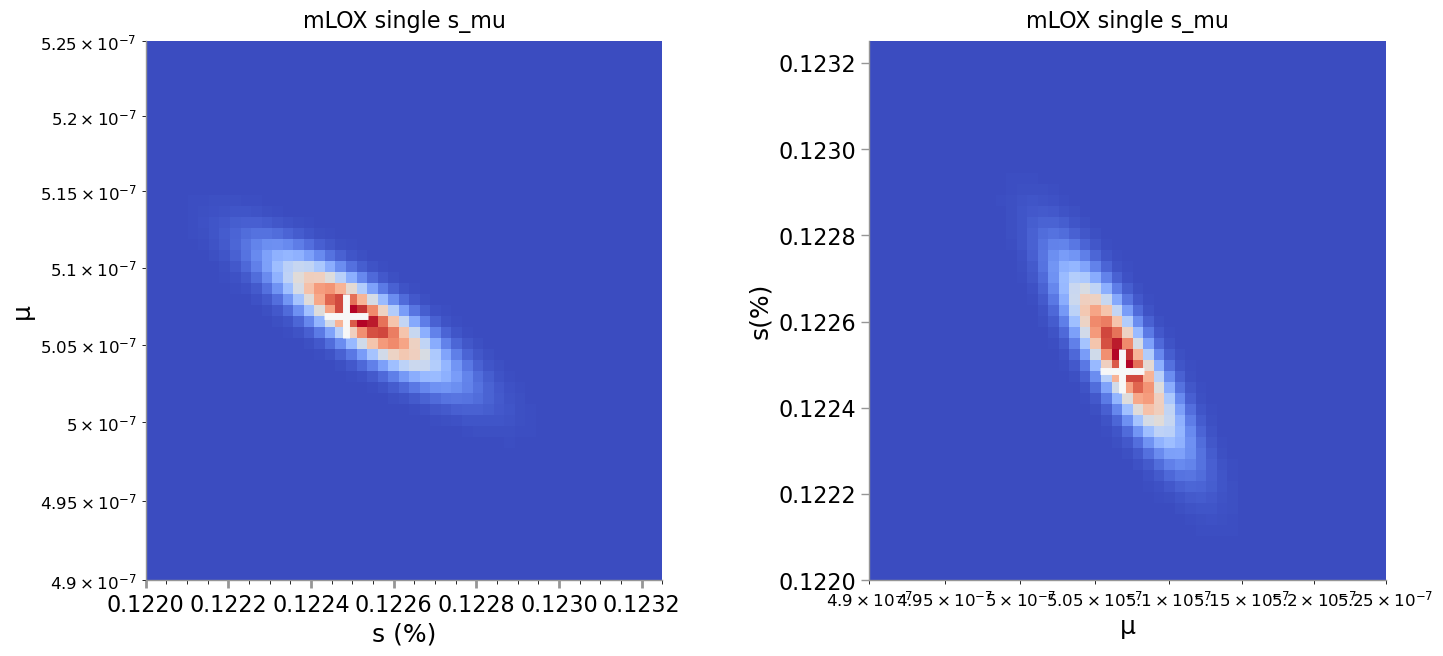

In [22]:
#Step 2 = calculate s and mu using heatmap
grid_size = 50
s_xyz, mu_xyz, s, mu = heatmap_logit_cumulative_subsample(cumulative_densities_list, s_range, mu_range, grid_size, 'X-', 'mLOX single s_mu', integral_limit)

In [23]:
print('s =', s)
print('mu = ', mu)

s = 0.12248469387755102
mu =  5.068412397446837e-07


No handles with labels found to put in legend.
No handles with labels found to put in legend.


95% confidence interval for s: lower s = 0.12225510204081633
95% confidence interval for s: upper s = 0.12273979591836734
95% confidence interval for μ: lower = 5.018702867916807e-07
95% confidence interval for μ: upper = 5.104220369202203e-07


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


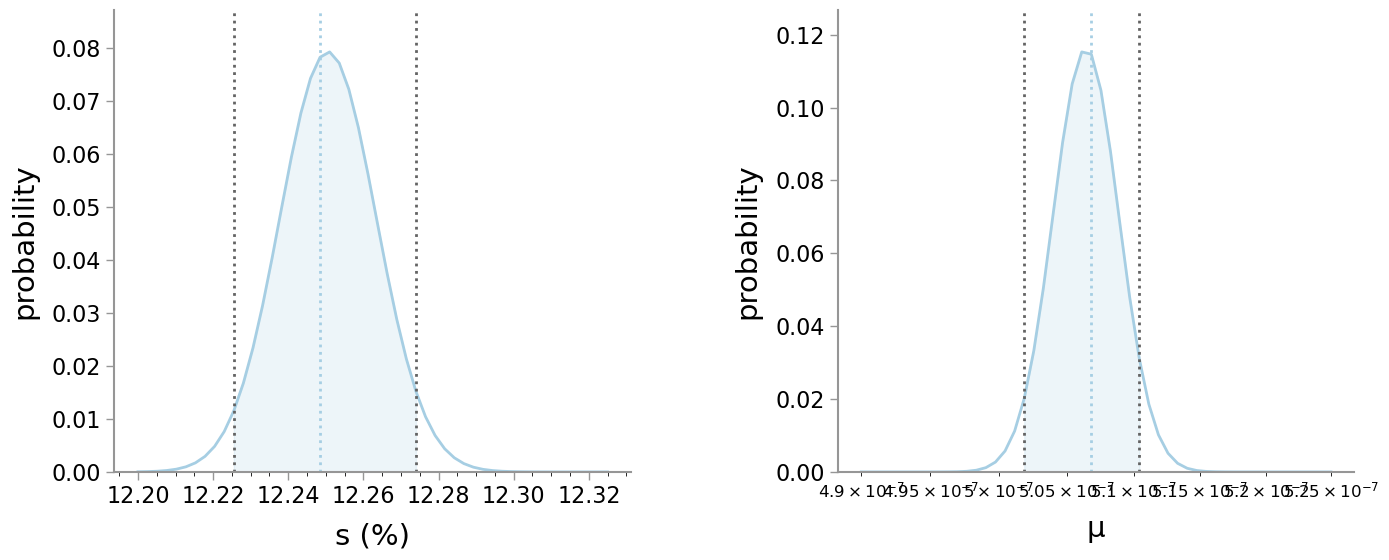

In [30]:
#Step 3 = calculate s and mu confidence intervals
lower95_s, upper95_s, lower95_mu, upper95_mu, s_probs_list, mu_probs_list = confidence_intervals_plot(s_xyz, mu_xyz, 'X-', 'mLOX single_s_mu')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log


histogram plotted


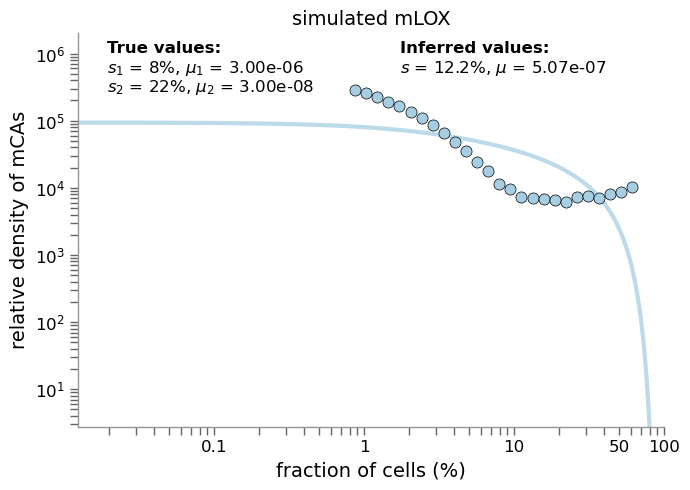

In [51]:
#Step 4 = plot the distribution
plot_MLE_single_distribution('X-', integral_limit, labelname, s, mu, log_cell_fractions, total_people)

# MLE for mLOX with 2 fitnesses (s1, s2) and 2 mutation rate (mu1, mu2)

In [52]:
labelname = 'mLOX'
lower_limit = 0.008
integral_limit = 0.67
total_people = 500000 #total in simulation
grid_size = 50

#s1 = Gridspaces for heatmaps for MLE for lower fitness effect, higher mu
lower_s1 = 0.0805
upper_s1 = 0.082
lower_mu1 = 2.7e-6
upper_mu1 = 2.95e-6

s1_range = [lower_s1, upper_s1]
mu1_range = [lower_mu1, upper_mu1]

#s2 = Gridspaces for heatmaps for MLE for higher fitness effect, lower mu
lower_s2 = 0.15
upper_s2 = 0.5
lower_mu2 = 2e-8
upper_mu2 = 6e-8

s2_range = [lower_s2, upper_s2]
mu2_range = [lower_mu2, upper_mu2]

In [37]:
#Step 1 = create list of logit cell fractions and cumulative densities
zf = zipfile.ZipFile('Simulation_results/Simulated_mLOX_with_2s_2mu/biobank_sim_test_s1_0.08_s2_0.22_u1_3e-06_u2_3e-08_N100000_seed3_biobank_variants.csv.zip')
df = pd.read_csv(zf.open('biobank_sim_test_s1_0.08_s2_0.22_u1_3e-06_u2_3e-08_N100000_seed3_biobank_variants.csv'))
log_cell_fractions, logit_cell_fractions = log_logit_CFs(df, lower_limit, integral_limit)

#split the data into 2 sets of cell fractions (one for the lower cell fractions, the other for the higher) and get the cell fraction breakpoint
log_cell_fractions_1, log_cell_fractions_2, logit_cell_fractions_1, logit_cell_fractions_2, lower_cell_fraction_break, upper_cell_fraction_break = separate_datapoint_list(log_cell_fractions)

#create list of cumulative densities for the 2 cell fraction lists
cumulative_densities_list1 = cumulative_cell_fraction_densities_list(logit_cell_fractions_1, total_people)
cumulative_densities_list2 = cumulative_cell_fraction_densities_list(logit_cell_fractions_2, total_people)

total mCAs = 75211
hist =  [12276 10971  9595  8167  7060  5877  4791  3671  2871  2099  1520  1048
   776   500   414   314   301   294   284   262   315   325   309   350
   376   445]
bins =  [-4.828295   -4.65802059 -4.48774617 -4.31747176 -4.14719734 -3.97692293
 -3.80664851 -3.6363741  -3.46609968 -3.29582527 -3.12555085 -2.95527644
 -2.78500203 -2.61472761 -2.4444532  -2.27417878 -2.10390437 -1.93362995
 -1.76335554 -1.59308112 -1.42280671 -1.25253229 -1.08225788 -0.91198346
 -0.74170905 -0.57143463 -0.40116022]
lower break =  -2.4444531957898454
lower break exp =  0.08677357008512292
upper break =  -1.9336299516525695
upper break exp =  0.14462227266081593


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


μ (ax1) =  3.2026577711153954e-08
s (ax1) = 0.20714285714285713
z max (ax1) =  1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



μ (ax2) =  3.2026577711153954e-08
s (ax2) = 0.20714285714285713
z max (ax2) =  1.0


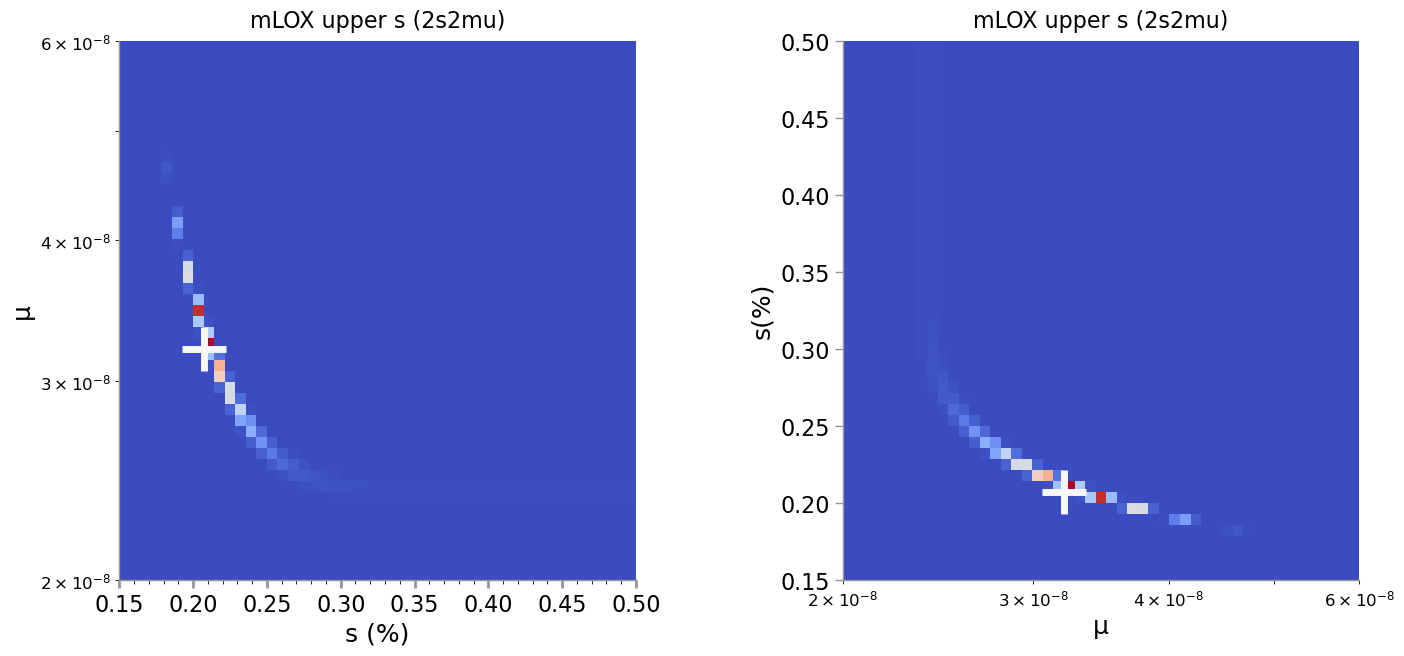

In [58]:
#Step 2 = calculate s2 and mu2 using heatmap
grid_size = 50
s2_xyz, mu2_xyz, s2, mu2 = heatmap_logit_cumulative_subsample(cumulative_densities_list2, s2_range, mu2_range, grid_size, 'X-', 'mLOX upper s (2s2mu)', integral_limit)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


95% confidence interval for s: lower s = 0.18571428571428572
95% confidence interval for s: upper s = 0.37142857142857144
95% confidence interval for μ: lower = 2.339861625517374e-08
95% confidence interval for μ: upper = 4.0075801611534707e-08


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


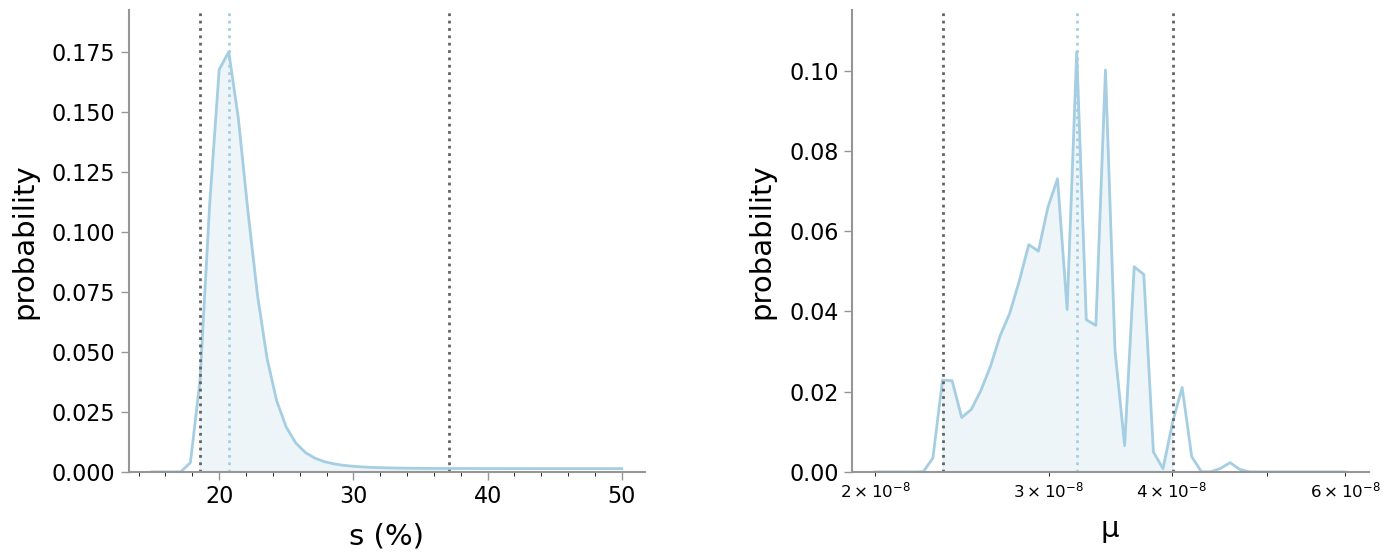

In [61]:
#Step 3 = calculate s2 and mu2 confidence intervals
lower95_s2, upper95_s2, lower95_mu2, upper95_mu2, s2_probs_list, mu2_probs_list = confidence_intervals_plot(s2_xyz, mu2_xyz, 'X-', 'mLOX upper s (2s2mu)')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


μ (ax1) =  2.79937454886309e-06
s (ax1) = 0.08129591836734694
z max (ax1) =  1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



μ (ax2) =  2.79937454886309e-06
s (ax2) = 0.08129591836734694
z max (ax2) =  1.0


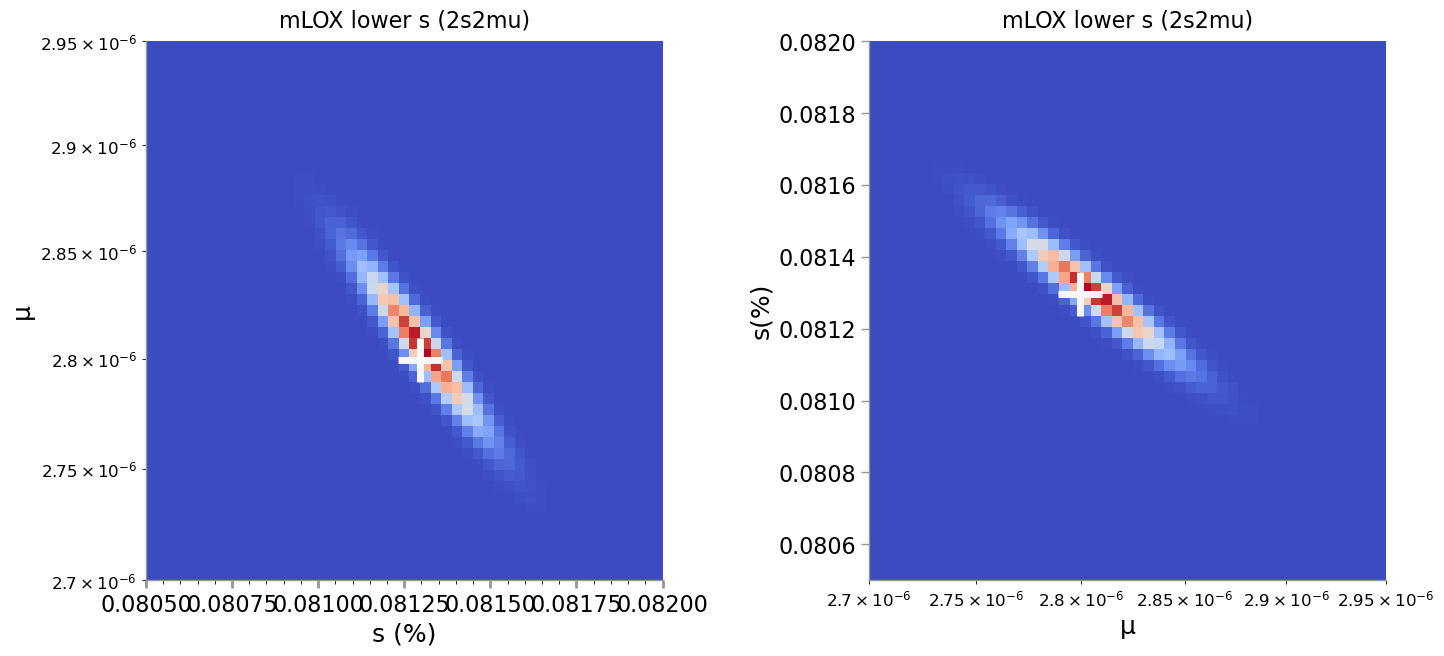

In [70]:
#Step 4 = calculate s1 and mu1 using heatmap
grid_size = 50
s1_xyz, mu1_xyz, s1, mu1 = heatmap_logit_cumulative_subsample_true_mu1(cumulative_densities_list1, s1_range, mu1_range, grid_size, 'X-', 'mLOX lower s (2s2mu)', lower_cell_fraction_break, mu2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


95% confidence interval for s: lower s = 0.08108163265306123
95% confidence interval for s: upper s = 0.0814795918367347
95% confidence interval for μ: lower = 2.7591932031537142e-06
95% confidence interval for μ: upper = 2.8452784223657484e-06


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


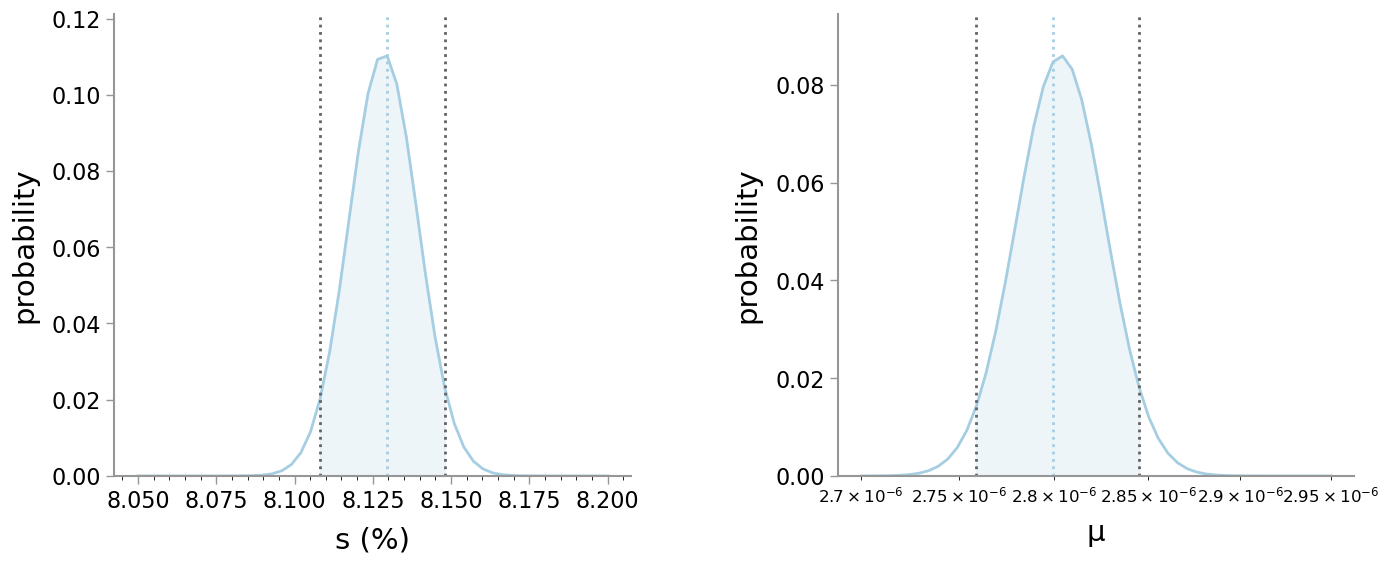

In [71]:
#Step 5 = calculate s1 and mu1 confidence intervals
lower95_s1, upper95_s1, lower95_mu1, upper95_mu1, s1_probs_list, mu1_probs_list = confidence_intervals_plot(s1_xyz, mu1_xyz, 'X-', 'mLOX lower s (2s2mu)')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


histogram plotted


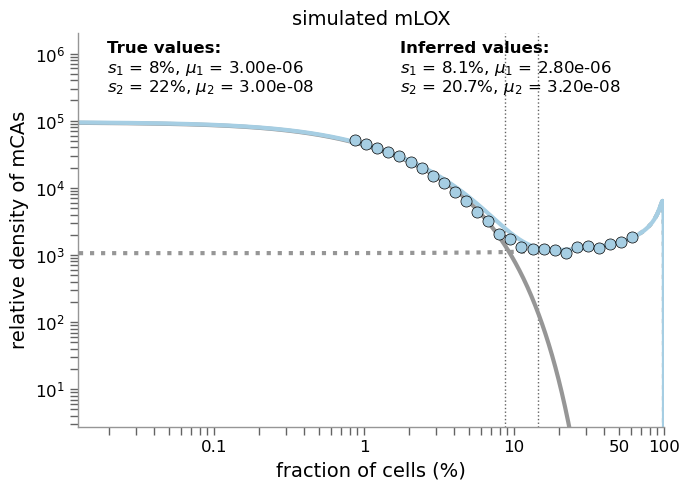

In [79]:
#Step 6 = plot the distribution of cell fractions with the 2 theory lines
plot_MLE_double_distributions('-', 0.67, 'simulated mLOX', s1, mu1, s2, mu2, log_cell_fractions, total_people, lower_cell_fraction_break, upper_cell_fraction_break)